In [2]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam
import numpy as np
import math
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [20]:
(XTrain,_),(_,_) = mnist.load_data()

In [21]:
print(XTrain.shape)

(60000, 28, 28)


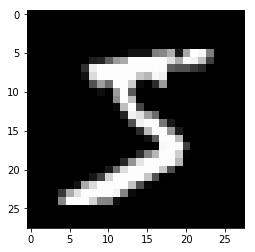

In [22]:
plt.imshow(XTrain[0],cmap='gray')
plt.show()

## Normalizing the Data

In [23]:
XTrain = (XTrain.astype('float32') - 127.5) /127.5
print(np.min(XTrain))
print(np.max(XTrain))
print(XTrain.shape)

-1.0
1.0
(60000, 28, 28)


In [24]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = int(XTrain.shape[0]/BATCH_SIZE)
HALF_BATCH =128
NOISE_DIM = 100 # UMSAMPLE INTO 784 DIM VECTOR
adam = Adam(lr=2e-4,beta_1=0.5) # This parameters work well for GAN

In [25]:
# CODE FOR GENERATOR
# INPUT NOISE (100 dim ) and output a vector (784 dim)


generator = Sequential()
generator.add(Dense(256,input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784,activation='tanh'))
generator.compile(loss = 'binary_crossentropy',optimizer=adam)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 784)               803600    
Total para

In [26]:
# Discriminator

discriminator = Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss = 'binary_crossentropy',optimizer=adam)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


## GAN

In [27]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

# Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

In [28]:
XTrain = XTrain.reshape(-1,784)
print(XTrain.shape)

(60000, 784)


c:\users\dipanshu\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 Disc Loss 0.6610 Generator Losss 0.9849
Epoch 2 Disc Loss 0.6609 Generator Losss 0.9888
Epoch 3 Disc Loss 0.6621 Generator Losss 0.9960
Epoch 4 Disc Loss 0.6625 Generator Losss 0.9843
Epoch 5 Disc Loss 0.6648 Generator Losss 0.9845


FileNotFoundError: [Errno 2] No such file or directory: 'images/gan_output_epoch_5.png'

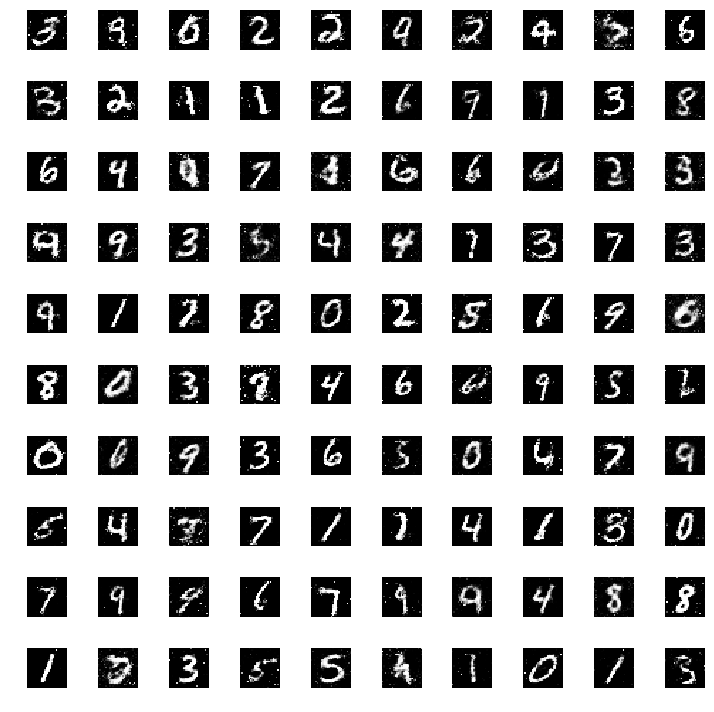

In [39]:
#Training Loop

d_losses = []
g_losses = []

for epoch in range(TOTAL_EPOCHS):
    epoch_d_loss=0.
    epoch_g_loss=0.
    
    #Mini Batch
    for step in range(NO_OF_BATCHES):
        idx = np.random.randint(0,XTrain.shape[0],HALF_BATCH)
        real_imgs = XTrain[idx]
        
        noise = np.random.normal(0,1,size=(HALF_BATCH,NOISE_DIM))
        fake_imgs = generator.predict(noise)
        
        real_y = np.ones((HALF_BATCH,1))*0.9
        fake_y = np.zeros((HALF_BATCH,1))
        
        d_loss_real = discriminator.train_on_batch(real_imgs,real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y)
        d_loss = 0.5*d_loss_fake + 0.5*d_loss_real
        
        epoch_d_loss +=d_loss
        
        noise =np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
        ground_truth_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,ground_truth_y)
        epoch_g_loss +=g_loss
        
    print("Epoch %d Disc Loss %.4f Generator Losss %.4f" % ((epoch+1),epoch_d_loss/NO_OF_BATCHES,epoch_g_loss/NO_OF_BATCHES))
    d_losses.append(epoch_d_loss/NO_OF_BATCHES)
    g_losses.append(epoch_g_loss/NO_OF_BATCHES)
    
    
    
    if (epoch+1)%5==0:
        generator.save('model/gan_generator_{0}.h5'.format(epoch+1))
        save_imgs(epoch)

In [37]:
def save_imgs(epoch,samples=100):
    
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    generated_img = generator.predict(noise)
    generated_img = generated_img.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_img[i],interpolation='nearest',cmap='gray')
        plt.axis("off")
    
    plt.tight_layout()
    plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()

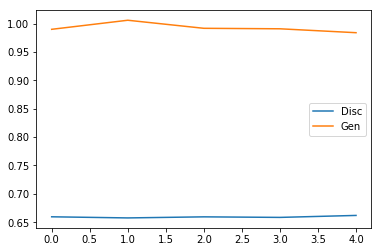

In [38]:
plt.plot(d_losses,label="Disc")
plt.plot(g_losses,label="Gen")
plt.legend()
plt.show()